In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def load_data(file_path):
    teams = []
    ranks = []
    outcomes = []
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            ranks.append(parts[0][1:-1])  
            teams.append(parts[1:-1])
            outcomes.append(parts[-1])
    
    return teams, ranks, outcomes

teams, ranks, outcomes = load_data('loomian_teams.txt')

In [11]:
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
all_loomians = sorted(list({mon for team in teams for mon in team}))
tokenizer = {token: idx for idx, token in enumerate(special_tokens + all_loomians)}
reverse_tokenizer = {idx: token for token, idx in tokenizer.items()}

rank_order = ['NOVICE', 'ADVANCED', 'HYPER', 'EXPERT', 'ACE']
rank_encoder = {rank: idx for idx, rank in enumerate(rank_order)}
reverse_rank_encoder = {idx: rank for rank, idx in rank_encoder.items()}

In [12]:
class LoomianDataset(Dataset):
    def __init__(self, teams, ranks, tokenizer, rank_encoder, max_len=10, team_size=7):
        self.tokenizer = tokenizer
        self.rank_encoder = rank_encoder
        self.max_len = max_len
        self.team_size = team_size
        self.samples = []
        
        for team, rank in zip(teams, ranks):
            team_tokens = [self.tokenizer.get(l, self.tokenizer['[UNK]']) for l in team]
            if len(team_tokens) < team_size:
                team_tokens += [self.tokenizer['[PAD]']] * (team_size - len(team_tokens))
            
            for i in range(1, team_size):
                input_seq = team_tokens[:i]
                target_seq = team_tokens[i:team_size]
                
                input_padded = input_seq + [self.tokenizer['[PAD]']] * (self.max_len - len(input_seq))
                target_padded = target_seq + [self.tokenizer['[PAD]']] * (self.max_len - len(target_seq))
                
                self.samples.append({
                    'input_ids': torch.tensor(input_padded),
                    'target_ids': torch.tensor(target_padded),
                    'rank': torch.tensor(self.rank_encoder[rank])
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'target_ids': torch.stack([item['target_ids'] for item in batch]),
        'rank': torch.stack([item['rank'] for item in batch])
    }

In [13]:
class LoomianPredictor(nn.Module):
    def __init__(self, vocab_size, rank_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rank_embedding = nn.Embedding(rank_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim * 2, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input_ids, rank):
        loomian_emb = self.embedding(input_ids)
        rank_emb = self.rank_embedding(rank).unsqueeze(1).expand(-1, input_ids.size(1), -1)
        combined = torch.cat([loomian_emb, rank_emb], dim=-1)
        lstm_out, _ = self.lstm(combined)
        logits = self.fc(lstm_out)
        return logits

In [14]:
dataset = LoomianDataset(teams, ranks, tokenizer, rank_encoder)
model = LoomianPredictor(len(tokenizer), len(rank_encoder))

EPOCHS = 200     
BATCH_SIZE = 64  
LR = 0.0005       

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer['[PAD]'])
optimizer = Adam(model.parameters(), lr=LR)
loss_history = []

Epoch 1/200, Loss: 4.8066
Epoch 2/200, Loss: 4.5942
Epoch 3/200, Loss: 4.4923
Epoch 4/200, Loss: 4.3250
Epoch 5/200, Loss: 4.1247
Epoch 6/200, Loss: 3.9252
Epoch 7/200, Loss: 3.7490
Epoch 8/200, Loss: 3.5900
Epoch 9/200, Loss: 3.4469
Epoch 10/200, Loss: 3.3248
Epoch 11/200, Loss: 3.2184
Epoch 12/200, Loss: 3.1167
Epoch 13/200, Loss: 3.0314
Epoch 14/200, Loss: 2.9590
Epoch 15/200, Loss: 2.8880
Epoch 16/200, Loss: 2.8252
Epoch 17/200, Loss: 2.7686
Epoch 18/200, Loss: 2.7238
Epoch 19/200, Loss: 2.6762
Epoch 20/200, Loss: 2.6359
Epoch 21/200, Loss: 2.5996
Epoch 22/200, Loss: 2.5637
Epoch 23/200, Loss: 2.5314
Epoch 24/200, Loss: 2.5006
Epoch 25/200, Loss: 2.4715
Epoch 26/200, Loss: 2.4494
Epoch 27/200, Loss: 2.4243
Epoch 28/200, Loss: 2.4033
Epoch 29/200, Loss: 2.3802
Epoch 30/200, Loss: 2.3598
Epoch 31/200, Loss: 2.3417
Epoch 32/200, Loss: 2.3204
Epoch 33/200, Loss: 2.3043
Epoch 34/200, Loss: 2.2849
Epoch 35/200, Loss: 2.2717
Epoch 36/200, Loss: 2.2575
Epoch 37/200, Loss: 2.2434
Epoch 38/2

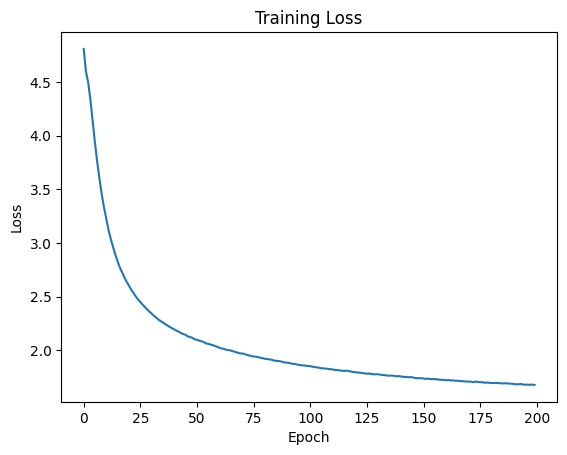

In [15]:
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids']
        target_ids = batch['target_ids']
        rank = batch['rank']
        
        logits = model(input_ids, rank)
        loss = criterion(logits.view(-1, len(tokenizer)), target_ids.view(-1))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss/len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
def predict_team(partial_team, rank, model, tokenizer, rank_encoder, max_length=7, max_attempts=100):
    model.eval()
    
    loomian_counts = defaultdict(int)
    for team in teams:
        for mon in team:
            loomian_counts[mon] += 1
    
    input_tokens = [tokenizer.get(l, tokenizer['[UNK]']) for l in partial_team]
    input_tensor = torch.tensor([input_tokens + [tokenizer['[PAD]']] * (dataset.max_len - len(input_tokens))])
    rank_tensor = torch.tensor([rank_encoder[rank]])
    
    predicted_team = partial_team.copy()
    attempts = 0
    
    while len(predicted_team) < max_length and attempts < max_attempts:
        attempts += 1
        try:
            with torch.no_grad():
                logits = model(input_tensor, rank_tensor)
            
            top_tokens = torch.topk(logits[0, len(predicted_team)-1], 5).indices.tolist()
            
            for token_id in top_tokens:
                next_token = reverse_tokenizer[token_id]
                if (next_token not in predicted_team and 
                    next_token not in special_tokens and
                    next_token != '[PAD]'):
                    predicted_team.append(next_token)
                    input_tokens = [tokenizer.get(l, tokenizer['[UNK]']) for l in predicted_team]
                    input_tensor = torch.tensor([input_tokens + [tokenizer['[PAD]']] * (dataset.max_len - len(input_tokens))])
                    break
        except KeyboardInterrupt:
            print("Prediction interrupted, returning current team")
            break
    
    if len(predicted_team) < max_length:
        candidates = sorted(
            [mon for mon in loomian_counts if mon not in predicted_team],
            key=lambda x: loomian_counts[x],
            reverse=True
        )
        predicted_team.extend(candidates[:max_length - len(predicted_team)])
    
    return predicted_team[:max_length]

In [20]:
test_cases = [
    (["Wintrix", "Joltooth"], "ACE")
]

for team, rank in test_cases:
    completion = predict_team(team, rank, model, tokenizer, rank_encoder)
    print(f"Input: {team} ({rank})")
    print(f"Predicted Team: {completion}")
    print()

Input: ['Wintrix', 'Joltooth'] (ACE)
Predicted Team: ['Wintrix', 'Joltooth', 'Ursnac', 'Zuelong', 'Dakuda', 'Tahtab', 'Stratusoar']



In [ ]:
import torch
import pickle
from pathlib import Path

torch.save(model.state_dict(), 'loomian_model_weights.pth', _use_new_zipfile_serialization=True)

with open('loomian_model_assets.pkl', 'wb') as f:
    pickle.dump({
        'tokenizer': tokenizer,
        'rank_encoder': rank_encoder,
        'max_len': dataset.max_len,
        'team_size': dataset.team_size,
        'model_config': {
            'vocab_size': len(tokenizer),
            'rank_size': len(rank_encoder),
            'embedding_dim': model.embedding.embedding_dim,
            'hidden_dim': model.lstm.hidden_size
        }
    }, f)